## Introduction

Zuerst laden wir die notwendigen Pakete. Zusätzlich werden die Daten importiert.

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy import stats
from sklearn.tree import plot_tree
import pandas as pd
import arff
data_freq = arff.load('D:/DS/Challenges/HUK/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower","VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('D:/DS/Challenges/HUK/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

Der Datenrahmen „df_freq“ enthält die Merkmale der Versicherungsnehmer sowie die Höhe des Risikos. Der Datenrahmen „df_sev“ enthält für einige dieser Versicherungsnehmer den „ClaimAmount“. Die Tabellen können über die Spalte „IDpol“ zusammengeführt werden. Dadurch entsteht ein neuer Datenrahmen, der alle Versicherungsnehmer enthält, die bei der Schadensmeldung einen Betrag erhalten haben. Beachten Sie, dass wir nur Einträge berücksichtigen, für die der ClaimAmount vorhanden ist. Die Einträge, die keinen entsprechenden ClaimAmount haben, gelten als nicht abgerechnete Ansprüche. Darüber hinaus gelten Einträge, für die ein Betrag beansprucht wird, deren Merkmale aber nicht vorhanden sind, als fehlend. Diese Einträge entfallen.

Wir stellen fest, dass es Versicherungsnehmer mit mehr als einem Anspruch gibt. Für diese Versicherungsnehmer rechnen wir die Höhe ihrer Ansprüche zusammen. Auf diese Weise werden mehrere Einträge zu diesen Versicherungsnehmern durch einen Eintrag ersetzt.

In [48]:
# Merging 2 datasets
df = pd.merge(df_freq, df_sev, how = 'inner', on = 'IDpol')
# Grouping by claim numbers and summing up the amount of claims per policyholder
df = df.groupby(by = list(df.columns[0:-1]), as_index = False).sum()
# moving the Exposure column to the end of dataframe
ex = df.pop('Exposure')
df.insert(11, ex.name, ex)

df

,IDpol,ClaimNb,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Exposure,ClaimAmount
0,139.0,1.0,'F',7.0,1.0,61.0,50.0,'B12',Regular,27000.0,'R11',0.75,303.00
1,190.0,1.0,'B',12.0,5.0,50.0,60.0,'B12',Diesel,56.0,'R25',0.14,1981.84
2,414.0,1.0,'E',4.0,0.0,36.0,85.0,'B12',Regular,4792.0,'R11',0.14,1456.55
3,424.0,2.0,'F',10.0,0.0,51.0,100.0,'B12',Regular,27000.0,'R11',0.62,10834.00
4,463.0,1.0,'A',5.0,0.0,45.0,50.0,'B12',Regular,12.0,'R73',0.31,3986.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24939,6113521.0,1.0,'C',4.0,1.0,26.0,60.0,'B12',Diesel,311.0,'R82',0.18,1324.40
24940,6113793.0,1.0,'C',7.0,2.0,51.0,50.0,'B12',Diesel,178.0,'R72',0.14,1769.88
24941,6113817.0,1.0,'D',4.0,0.0,35.0,51.0,'B12',Regular,1719.0,'R82',0.17,1288.28
24942,6113834.0,2.0,'C',15.0,3.0,36.0,50.0,'B12',Regular,181.0,'R54',0.17,12230.40


Wir löschen die IDpol-Spalte, da sie nicht mehr benötigt wird. Darüber hinaus wird die Schadensfallnummer erst nach der Geltendmachung von Schadensfällen ermittelt und kann nicht als prädiktives Merkmal angesehen werden. Deshalb lassen wir es fallen! Bemerkenswert ist, dass die aggregierten Daten keine fehlenden Werte enthalten.

In [49]:
# Drop IDpol: The IDpol is not needed anymore
df = df.drop(columns = ['IDpol', 'ClaimNb'])
df.isna().sum()

Area           0
VehPower       0
VehAge         0
DrivAge        0
BonusMalus     0
VehBrand       0
VehGas         0
Density        0
Region         0
Exposure       0
ClaimAmount    0
dtype: int64

## Exploratory Data Analysis

Wir beginnen mit der Erstellung der grundlegenden deskriptiven Statistiken der Daten.

In [50]:
df.describe()

,VehPower,VehAge,DrivAge,BonusMalus,Density,Exposure,ClaimAmount
count,24944.000000,24944.000000,24944.000000,24944.000000,24944.000000,24944.000000,2.494400e+04
mean,6.468970,7.386225,45.139793,64.930164,1984.306166,0.692669,2.401749e+03
std,2.012848,5.173621,14.658487,19.864719,4119.719566,0.313969,3.026475e+04
min,4.000000,0.000000,18.000000,50.000000,2.000000,0.002740,1.000000e+00
25%,5.000000,3.000000,34.000000,50.000000,111.000000,0.450000,7.497875e+02
50%,6.000000,7.000000,45.000000,55.000000,495.000000,0.760000,1.172000e+03
75%,7.000000,11.000000,54.000000,76.000000,2120.000000,1.000000,1.346400e+03
max,15.000000,99.000000,99.000000,228.000000,27000.000000,2.000000,4.075401e+06


Die Variable „claimAmount“ hat eine Preiseinheit und ist unverhältnismäßig (75 % der Datenpunkte sind kleiner als 2000 und der Maximalwert liegt in Millionen). Um die Daten ordnungsgemäß untersuchen zu können, wird die Protokolltransformation dieser Variablen berücksichtigt. Auf diese Weise wird nicht nur die Variable näher an die anderen kontinuierlichen Variablen skaliert, sondern es kann auch die Normalität der Variablen überprüft werden.

In [51]:
df_explore = df.copy(deep = True)
df_explore['ClaimAmount'] = np.log10(df_explore['ClaimAmount'])

Als nächstes zeichnen wir das Histogramm von ClaimAmount. Um die Normalität weiter zu überprüfen, erstellen wir auch die Q-Q-Diagramme gegen die Standardnormalverteilung. Darüber hinaus wird die (lineare) Pearson-Korrelation zwischen kontinuierlichen Variablen abgeleitet.

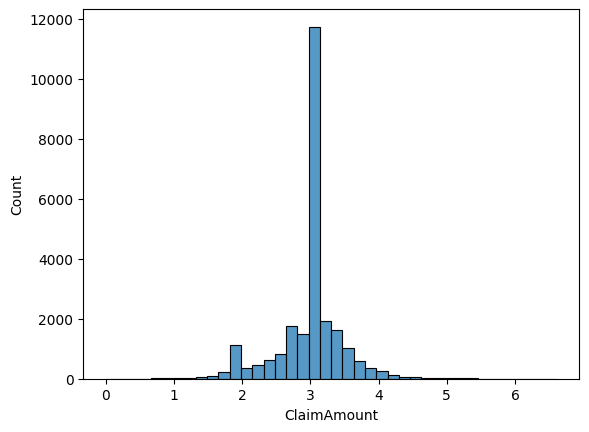

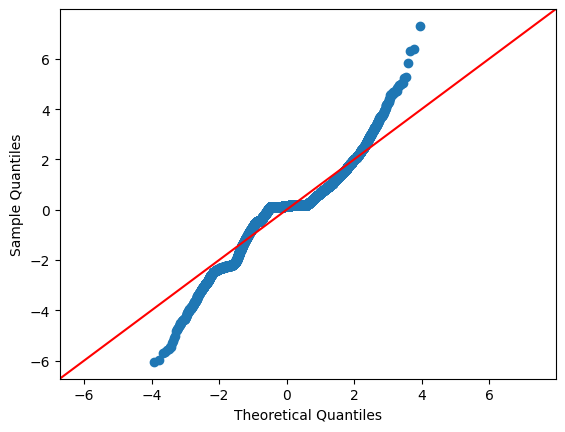

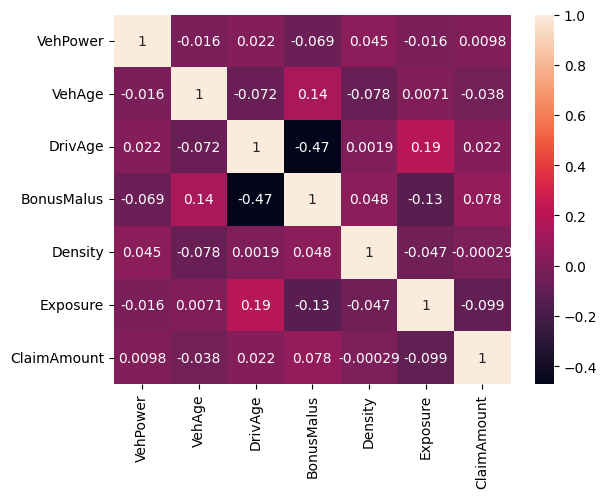

In [52]:
# Correlation between variables
sns.histplot(x = 'ClaimAmount', data = df_explore, bins = 40)
ca = df_explore['ClaimAmount']
ca = (ca - ca.mean())/(ca.std())
sm.qqplot(data = ca, line = '45')
plt.subplots()
sns.heatmap(df_explore.select_dtypes(include = 'float').corr(), annot = True)
plt.show()

Der ClaimAmount sieht nicht normal aus. Die Verteilung ist nicht vollständig symmetrisch. Etwa 50 % der Werte konzentrieren sich auch in einem kleinen Bereich (d. h. extreme Kurtosis). Die Q-Q-Diagramme zeigen die Abweichung zur Standardnormalverteilung viel besser. Die Enden der ClaimAmount-Verteilung weichen von denen der Normalverteilung ab.

Darüber hinaus sind die Korrelationskoeffizienten zwischen Merkmalen und Antwort gering. Der höchste lineare Koeffizient liegt zwischen Exposure und DrivAge (0,19). Dies widerlegt zumindest den linearen Zusammenhang zwischen den kontinuierlichen Merkmalen und den Antworten.

Im Folgenden wenden wir weitere EDA an:

Area: Offensichtlich hängt die Höhe der Exposure stark von der Area ab. Die in Density enthaltenen Informationen sind auch in Area enthalten. Das dritte Diagramm zeigt, dass die Anzahl der Schadensfälle im Gebiet „F“ mit höherer Dichte geringer ist als in den übrigen Gebieten.

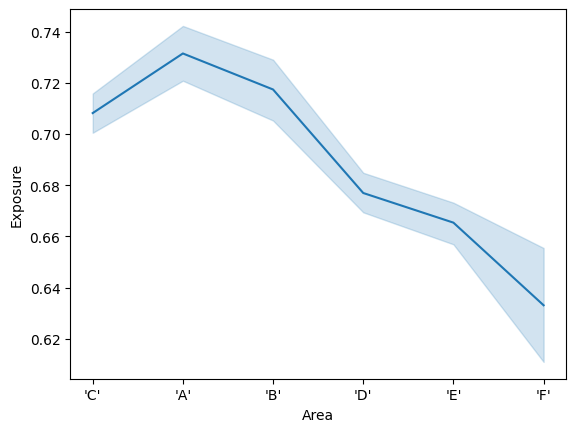

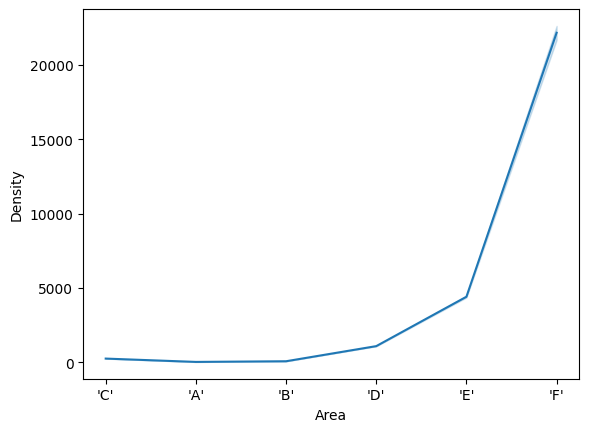

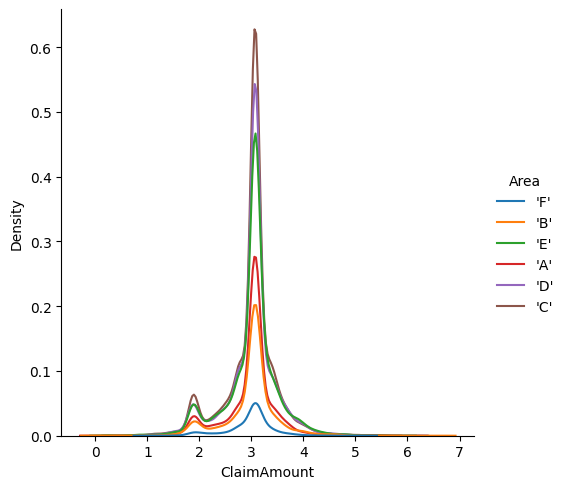

In [53]:
sns.lineplot(x = 'Area', y = 'Exposure', data = df_explore.sort_values(by="Exposure"))
plt.subplots()
sns.lineplot(x = 'Area', y = 'Density', data = df_explore.sort_values(by="Exposure"))
sns.displot(x = 'ClaimAmount', hue = 'Area', data = df_explore, kind = 'kde')
plt.show()

Region: Es scheint, dass die Region kein guter Indikator für die Anspruchshöhe oder das Risiko ist, daher können wir sie in den Funktionen weglassen.

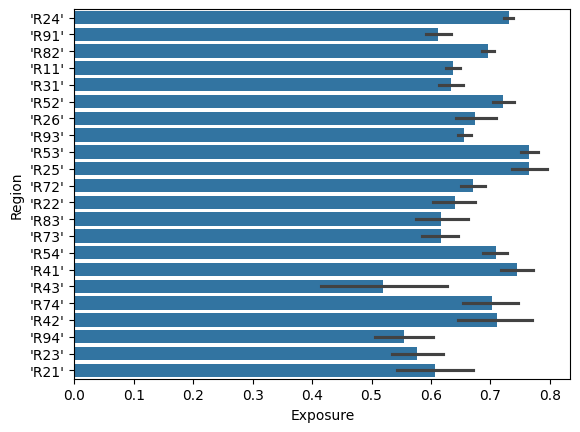

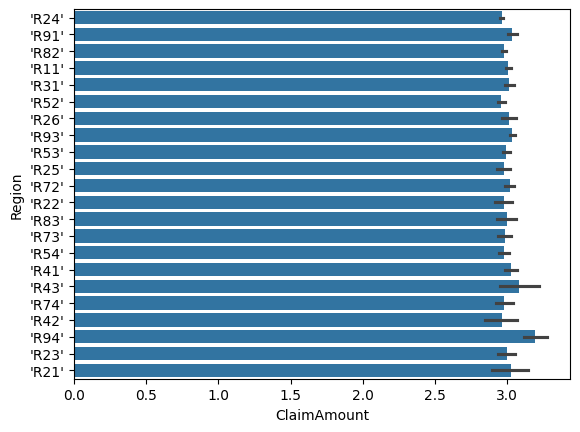

In [54]:
sns.barplot(y = 'Region', x = 'Exposure', data = df_explore.sort_values(by="Exposure"))
plt.subplots()
sns.barplot(y = 'Region', x = 'ClaimAmount', data = df_explore.sort_values(by="Exposure"))
plt.show()

Fahralter: Es besteht offensichtlich ein Zusammenhang zwischen dem Fahralter und der Exposition. Zudem sinkt der Bonus-Malus mit zunehmendem Fahralter. Diese Korrelation erfolgt nahezu linear (mit Koeffizient -0,47, wie aus der Tabelle der Korrelationskoeffizienten ersichtlich)

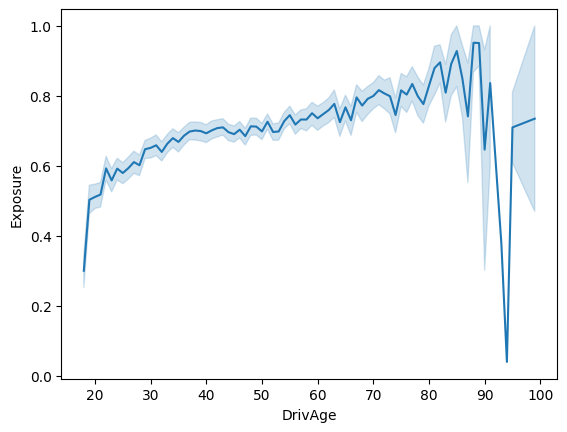

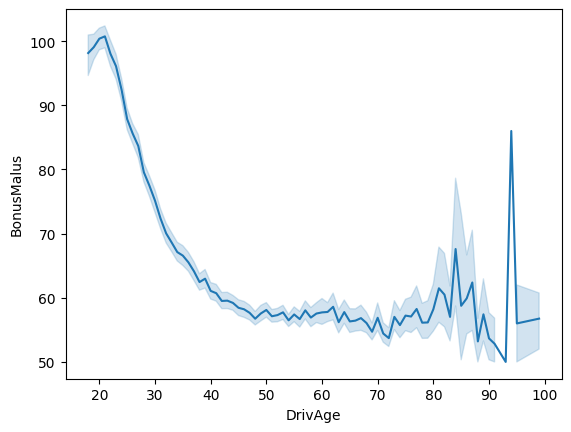

In [55]:
sns.lineplot(x = 'DrivAge', y = 'Exposure', data = df_explore)
plt.subplots()
sns.lineplot(x = 'DrivAge', y = 'BonusMalus', data = df_explore)
plt.show()

VehBrand: Einige Marken, die überwiegend über eine geringe Fahrzeugleistung verfügen, haben mehr Ansprüche eingereicht.

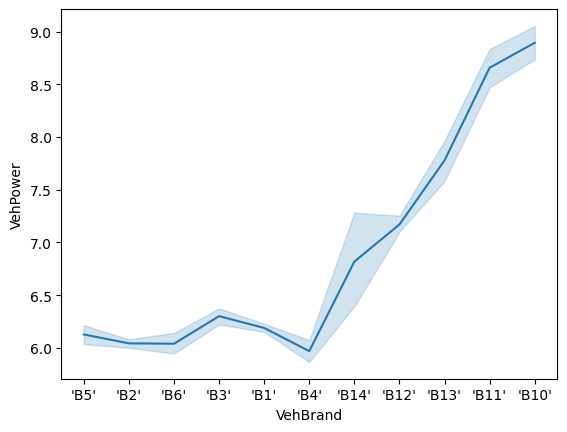

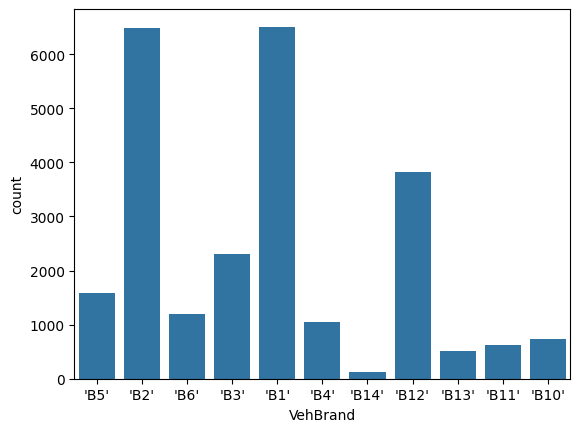

In [56]:
sns.lineplot(x = 'VehBrand', y = 'VehPower', data = df_explore.sort_values(by = 'VehPower'))
plt.subplots()
sns.countplot(x = 'VehBrand', data = df_explore.sort_values(by = 'VehPower'))
plt.show()

VehAge: Die Plots zeigen, dass alte Fahrzeuge zwar deutlich weniger Schadensfälle, dafür aber höhere Schadenssummen einreichen. Das liegt wahrscheinlich daran, dass es sich bei den meisten alten Autos um Oldtimer handelt. In diesen Fällen kann es zu einigen Ausreißern kommen.

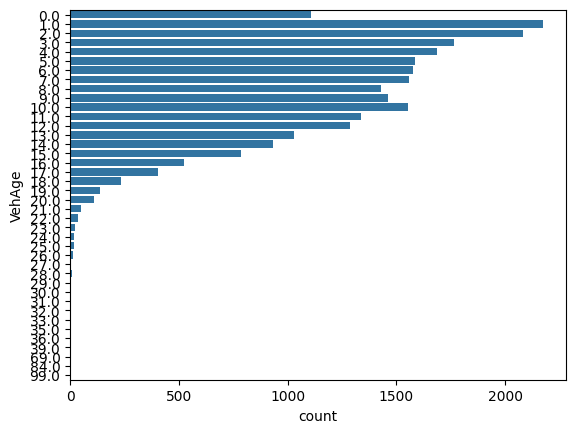

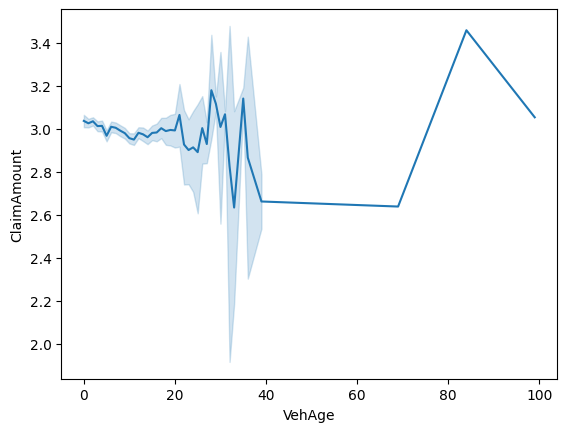

In [57]:
sns.countplot(y = 'VehAge', data = df_explore)
plt.subplots()
sns.lineplot(x = 'VehAge', y = 'ClaimAmount', data = df_explore)
plt.show()

## Results

Wie wir gesehen haben, folgt der ClaimAmount auch nach der Protokolltransformation keiner Normalverteilung. Darüber hinaus gibt es keinen klaren Hinweis auf eine lineare Abhängigkeit zwischen Merkmalen und Reaktionen. Daher entscheiden wir uns, mit Entscheidungsbäumen fortzufahren. Darüber hinaus untersuchen wir die geeigneteren Ensemble-Methoden für unseren Lernprozess: Random Forests und stochastische gradient boosting. Es versteht sich von selbst, dass wir es mit numerischen Antworten zu tun haben und unser Problem daher vom Typ Regression ist.

Um die Modellleistung zu berücksichtigen, wählen wir den root-mean-squared=error (RMSE).

### Feature-Engineering
Entscheidungsbäume treffen fundierte Entscheidungen zur Schichtung der Daten auf der Grundlage der durch verschiedene Merkmale gewonnenen Informationen. Daher werden wir den Prozess der Merkmalsauswahl einschränken und ihn zur Optimierung dem Modell überlassen. Darüber hinaus sehen wir davon ab, die Forderungsbeträge umzuwandeln. Dadurch kann das Modell die Auswirkung von Ausreißern berücksichtigen.

Wir betrachten die folgenden Feature-Engineering-Schritte:
1. Sinkende Dichte und Region (die Anspruchshöhe ist gleichmäßig auf die Regionen verteilt und die in der Dichte enthaltenen Informationen sind höchstwahrscheinlich in der Flächenvariablen enthalten)
2. Fassen Sie Marken in zwei Kategorien mit hohen und niedrigen Anspruchszahlen zusammen
3. Konvertieren der kategorialen Merkmale in numerische.


In [58]:
# droping density and region
dfx = df.drop(columns = ['Density', 'Region'])

# brand mapping
dfx["VehBrand"] = dfx["VehBrand"].str.replace("'","")
brand_mapping = {'B1':'high', 'B2':'high', 'B3':'few', 'B4':'few', 'B5':'few', 'B6':'few', 'B12':'few' , 'B10':'few', 'B11':'few', 'B13':'few', 'B14':'few'}
brands = dfx.VehBrand.map(brand_mapping)
dfx['Brands'] = brands
dfx.drop(columns = 'VehBrand')

# categories to numbers
col = dfx.select_dtypes(include='object').columns
dfx[col] = dfx.select_dtypes(include='object').astype('category')

for c in col:
    dfx[c] = dfx[c].cat.codes

dfx

,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Exposure,ClaimAmount,Brands
0,5,7.0,1.0,61.0,50.0,3,1,0.75,303.00,0
1,1,12.0,5.0,50.0,60.0,3,0,0.14,1981.84,0
2,4,4.0,0.0,36.0,85.0,3,1,0.14,1456.55,0
3,5,10.0,0.0,51.0,100.0,3,1,0.62,10834.00,0
4,0,5.0,0.0,45.0,50.0,3,1,0.31,3986.67,0
...,...,...,...,...,...,...,...,...,...,...
24939,2,4.0,1.0,26.0,60.0,3,0,0.18,1324.40,0
24940,2,7.0,2.0,51.0,50.0,3,0,0.14,1769.88,0
24941,3,4.0,0.0,35.0,51.0,3,1,0.17,1288.28,0
24942,2,15.0,3.0,36.0,50.0,3,1,0.17,12230.40,0


### Model

Bevor wir mit der Modellierung fortfahren, erstellen wir einige Funktionen und Variablen, um den Prozess zu erleichtern.

In [59]:
# setting up hyper-parameters
seed = 123
min_leaves = 0.2
min_split = 0.2
depth = 5
estimators_num = 500
responses = ['ClaimAmount', 'Exposure']

In [60]:
# splitting data to train and test datasets
X = dfx.drop(responses, axis = 1)
def data_prep (data, response):
    y = data[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed)
    return X_train, X_test, y_train, y_test

In [61]:
# Plots
def plots(features, model, claim_pred, claim_test, exp_pred, exp_test):
    # feature importance
    important_features = pd.Series(model.feature_importances_, index = features).sort_values()
    important_features.plot(kind = 'barh')
    '''plt.subplots()
    res1 = claim_test - claim_pred
    res1 = (res1 - res1.mean())/res1.std()
    print(res1.max())
    plt.scatter(x = claim_pred, y = claim_test, s = 4) 
    plt.subplots()
    res2 = exp_test - exp_pred
    res2 = (res2 - res2.mean())/res2.std()
    plt.scatter(x = exp_pred, y = res2, s = 4)'''
    plt.show()
    

In [62]:
## RMSE
def model_performance(X_train, X_test, y_train, y_test, model):
    train_pred = model.predict(X_train)
    rmse_train = mean_squared_error(y_train, train_pred, multioutput = 'raw_values')**(1/2)
    print('Training RMSE: ' + str(rmse_train))
    y_pred = model.predict(X_test)
    rmse_test = mean_squared_error(y_test, y_pred, multioutput = 'raw_values')**(1/2)
    print('Test RMSE: ' + str(rmse_test))
    if len(y_train) == 2:
        plots(X.columns, model, y_pred[:,0], y_test['ClaimAmount'], y_pred[:,1], y_test['Exposure'])
        out = y_pred[:,0]
    else:
        plots(X.columns, model, y_pred, y_test, y_pred, y_test)
        out = y_pred
    return rmse_train, rmse_test, out

Modell 1. Entscheidungsbaum: Um eine Überanpassung zu vermeiden, schränken wir das Modell ein, indem wir mehrere Parameter festlegen.

Training RMSE: [1.79305081e+04 3.09775814e-01]
Test RMSE: [4.79744662e+04 3.09878694e-01]


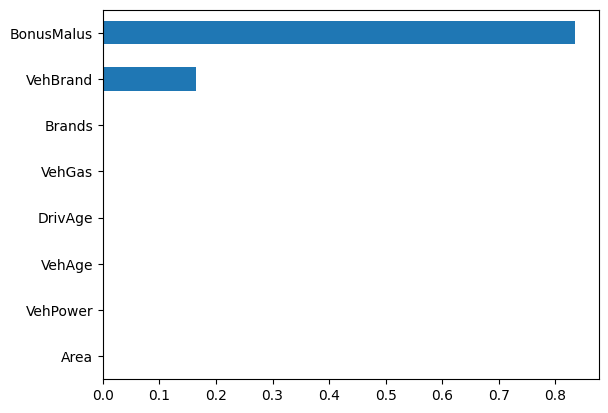

In [63]:
# model 1. Decision Tree
X_train, X_test, y_train, y_test = data_prep (dfx, responses)
dt_base = DecisionTreeRegressor(max_depth = depth, 
                                min_samples_leaf = min_leaves, 
                                min_samples_split = min_split, 
                                random_state = seed)
dt_base.fit(X_train, y_train)
rmse_train, rmse_test, out = model_performance(X_train, X_test, y_train, y_test, dt_base)


Modell 2. Random Forrest: Hier wird ein zusätzlicher Parameter, nämlich die Anzahl der Schätzer, angegeben. Dies ist die Anzahl der Bootstrap-Datensätze, die den Entscheidungsbäumen zugeführt werden.

Training RMSE: [1.79302467e+04 3.09065065e-01]
Test RMSE: [4.79764556e+04 3.09407484e-01]


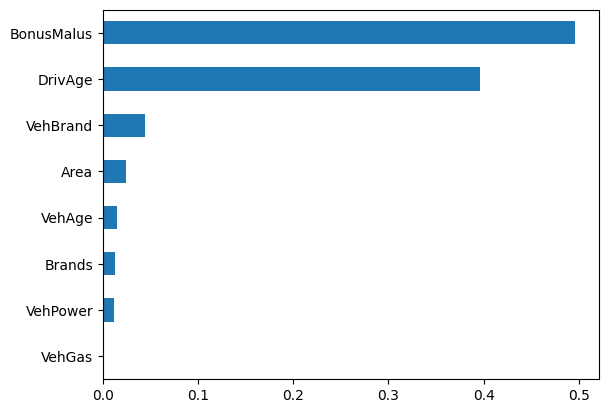

In [64]:
# model 2. Random Forrests
X_train, X_test, y_train, y_test = data_prep (dfx, responses)
rfr = RandomForestRegressor(max_depth = depth, 
                            min_samples_leaf = min_leaves, 
                            min_samples_split = min_split, 
                            random_state = seed, 
                            n_estimators = estimators_num, 
                            n_jobs = -1)
rfr.fit(X_train, np.array(y_train))
rmse_train, rmse_test, out = model_performance(X_train, X_test, y_train, y_test, rfr)

Modell 3. Stochastic Gradient Boosting (SGB): Dieses Modell verfügt über drei zusätzliche Parameter. Lernrate, Teilstichprobe und max_features. Zur besseren Verallgemeinerung werden die Werte wie folgt festgelegt.

Training RMSE: [11912.75561421]
Test RMSE: [49797.36402563]


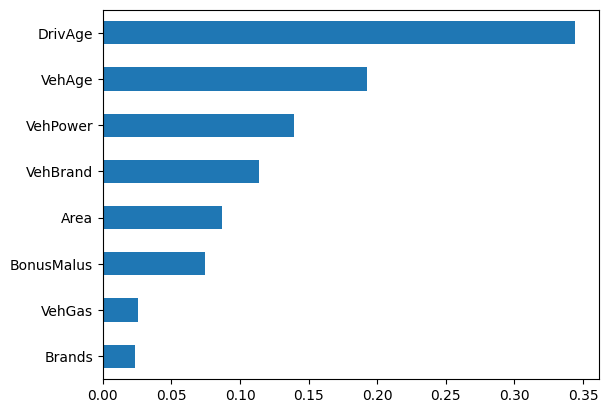

Training RMSE: [0.27778564]
Test RMSE: [0.29779984]


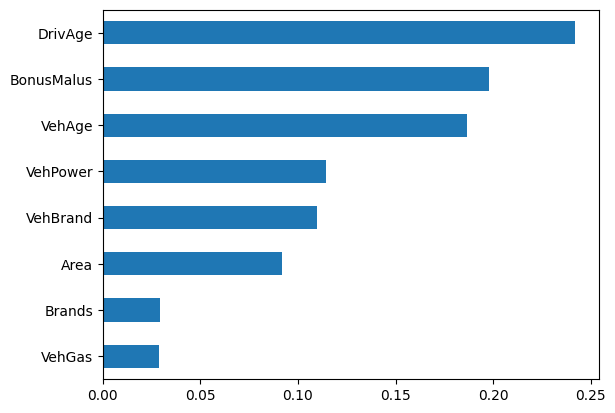

In [65]:
# Model 3. Stochastic Gradient Boosting
X_train, X_test, y_train, y_test = data_prep (dfx, 'ClaimAmount')
SGB_claim = GradientBoostingRegressor(max_depth = depth, 
                                      learning_rate = 0.05, 
                                      n_estimators = estimators_num, 
                                      subsample = 0.2, 
                                      max_features = 0.3, 
                                      random_state = seed)
SGB_claim.fit(X_train, y_train)
rmse_train, rmse_test, out_claim = model_performance(X_train, X_test, y_train, y_test, SGB_claim)
plt.subplots()
X_train, X_test, y_train, y_test = data_prep (dfx, 'Exposure')
SGB_exp = GradientBoostingRegressor(max_depth = depth, 
                                    learning_rate = 0.05, 
                                    n_estimators = estimators_num, 
                                    subsample = 0.2, 
                                    max_features = 0.3, 
                                    random_state = seed)
SGB_exp.fit(X_train, y_train)
rmse_train, rmse_test, out_exp = model_performance(X_train, X_test, y_train, y_test, SGB_exp)

## Conclusions

Die Modelle schneiden eher schlecht ab. Allerdings weisen der Entscheidungsbaum und der Zufallswald unter den trainierten Modellen einen kleineren RMSE auf und sind daher bessere Modelle zur Vorhersage der Anspruchshöhe. Andererseits kann SGB die Exposition mit einem kleineren RMSE besser vorhersagen. Wir können die voraussichtliche Schadenshöhe in einem Jahr pro Versicherungsnehmer wie folgt ableiten:


In [66]:
expected_claim = (out_claim/out_exp).mean()
expected_claim

4057.742539346988



Um den Datensatz weiter zu untersuchen und ein besseres Modell zu finden, kann man wie folgt vorgehen:

1. Apply hyper parameter tuning
2. Cross-Validation
3. Outlier detection